In [1]:

import numpy as np

from model.helper import *
from model.utils import *
import nibabel as nib
import nilearn.plotting as plotting
import hcp_utils as hcp
from sklearn.gaussian_process.kernels import RBF, Matern

import pandas as pd
import numpy as np
import nibabel as nib
from model.utils import save_pickle, load_pickle
from model.helper import scale
import matplotlib.pyplot as plt
import torch

from model.helper import matern_kernel, ker_approx


import model.SIMBA_VI as SIMBA_VI
import model.SIMBA_Gibbs as SIMBA_Gibbs
import model.BML as BML

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [2]:
path = f"data/abcd"

time = "baseline"
#hemi='left'
hemi='right'

In [ ]:
covariates = pd.read_csv(f'{path}/{time}_covariates.tsv', sep='\t', header=0)
covariates["site"] = np.where(covariates["site"] == 22, 1, covariates["site"])
site_ids = np.sort(covariates["site"].unique())
X = covariates.values

array([[ 0.18891765, -0.52566493, 10.83333333,  1.        , 14.        ],
       [ 0.95550665,  1.14159817,  9.33333333,  0.        , 12.        ],
       [ 0.14528393,  0.51560172, 10.25      ,  0.        , 16.        ],
       ...,
       [ 0.81139287, -0.12241897, 10.33333   ,  1.        ,  6.        ],
       [ 0.07528486, -0.07330177,  9.        ,  0.        , 11.        ],
       [ 0.87181797, -0.10319908, 10.91667   ,  0.        , 14.        ]])

In [4]:
n_site = len(site_ids)
n_site

21

In [ ]:
Y = pd.read_csv(f'{path}/{time}_{hemi}_values.csv',header=None)
Y = Y.values

array([[ 0.42486,  0.26946, -1.4332 , ...,  1.80282, -0.34814,  0.79138],
       [ 0.90491, -3.97548,  0.30986, ..., -0.50062, -0.82396, -1.32208],
       [ 1.10921,  0.18838, -0.75615, ..., -1.03519, -0.30451, -1.42336],
       ...,
       [ 2.34685, -5.10382, -3.89898, ...,  3.28546,  3.16085,  4.09387],
       [-2.54838, -1.37961, -1.06416, ..., -0.96562, -3.21053, -0.83722],
       [-2.45134,  0.42836, -1.78087, ..., -0.90108, -0.32471, -0.97741]])

In [ ]:
S = pd.read_csv(f'{path}/{hemi}_grids.csv')
S = scale(S).values

array([[-0.92144643, -0.34205384,  0.28312232],
       [-0.47105635, -0.29611056,  0.9797591 ],
       [ 0.61671647,  0.18711905,  0.52117248],
       ...,
       [ 0.94277793, -0.24390672, -0.42926412],
       [ 0.94649477, -0.24449914, -0.41425837],
       [ 0.94040423, -0.25886973, -0.41960783]])

In [7]:
dtype = torch.float32
S = torch.from_numpy(S).to(dtype)
Y = torch.from_numpy(Y).to(dtype)
X = torch.from_numpy(X).to(dtype)

In [8]:
Y_site_list=[]
X_site_list=[]
for id in site_ids:
    # leave one site out
    Y_site = Y[X[:,-1] == id]
    X_site = X[X[:,-1] == id]
    X_site = X_site[:,:-1]
    Y_site_list.append(Y_site)
    X_site_list.append(X_site)

In [9]:
# keep one site  data
site_data=[]
siteloo_data=[]
for id in site_ids:
    # leave one site out
    Y_site = Y_site_list[id-1]
    X_site = X_site_list[id-1]
    
    mean = X_site[:,:3].mean(axis=0)
    std = X_site[:,:3].std(axis=0)

    Y_loo = torch.cat(Y_site_list[:id-1] + Y_site_list[id:])
    X_loo = torch.cat(X_site_list[:id-1] + X_site_list[id:])

    site_data.append({'X': X_site,
            'Y': Y_site})
    siteloo_data.append({'X': X_loo,
            'Y': Y_loo})
data_list = {'site_data':site_data,
             'siteloo_data':siteloo_data,
             'X':X,
             'Y':Y,
             'grid': S}
#save_pickle(data_list, f'data/abcd/site_data.pickle')
    

In [10]:
X = X[:,:-1]

In [19]:
L = 675
L_eta = int(0.1*L)
kernel = Matern(length_scale=0.1, nu=1.5)


In [ ]:

vi_mse = []
for site in range(n_site):
    X_train = site_data[site]['X']
    Y_train = site_data[site]['Y']
    X_test = siteloo_data[site]['X']
    Y_test = siteloo_data[site]['Y']
    X_test = torch.column_stack((torch.ones(X_test.shape[0]), X_test))
    model = SIMBA_VI.SIMBA_VI(Y=Y_train, X=X_train,grids=S,
                        kernel = kernel, L = L, L_eta = L_eta, 
                        verbose=-1, include_intercept=True)
    paras, profile = model.run(verbose=False)
    
    Y_pred = (X_test @ paras['E_alpha'])[:,None] + X_test @ (paras['E_theta_beta'] @ model.basis.t())
    vi_mse.append(((Y_pred - Y_test) ** 2).mean())
save_pickle(vi_mse, f'results/abcd/{time}_{hemi}_SIMBA_VI_mse.pickle')

In [ ]:
N, V = Y.shape
n_ind = torch.arange(0,N)
vi_results = []
gibbs_mse=[]
for site in range(n_site):
    X_train = site_data[site]['X']
    Y_train = site_data[site]['Y']
    X_test = siteloo_data[site]['X']
    Y_test = siteloo_data[site]['Y']
    X_test = torch.column_stack((torch.ones(X_test.shape[0]), X_test))

    model = SIMBA_Gibbs.SIMBA_Gibbs(Y=Y_train, X= X_train, grids=S,
                                kernel = kernel, L = L, L_eta = L_eta, 
                                burnin=5000, mcmc_sample=1000, thin=1,
                                dtype=dtype, include_intercept=True)
    samples = model.run(n_chains=1, parallel = False)
    mcmc_alpha = samples['alpha'].mean((0,1))
    mcmc_theta_beta = samples['theta_beta'].mean((0,1))
    Y_pred = (X_test @ mcmc_alpha)[:,None] + X_test @ (mcmc_theta_beta @ model.basis.t())
    gibbs_mse.append(((Y_pred - Y_test) ** 2).mean())
save_pickle(gibbs_mse, f'results/abcd/{time}_{hemi}_SIMBA_Gibbs_mse.pickle')

100%|██████████| 6000/6000 [00:38<00:00, 157.51it/s]


Chain 1 finished in 38.16 seconds


100%|██████████| 6000/6000 [01:35<00:00, 62.99it/s]


Chain 1 finished in 95.25 seconds


100%|██████████| 6000/6000 [01:22<00:00, 72.44it/s]


Chain 1 finished in 82.83 seconds


100%|██████████| 6000/6000 [00:48<00:00, 124.53it/s]


Chain 1 finished in 48.18 seconds


100%|██████████| 6000/6000 [01:04<00:00, 93.49it/s] 


Chain 1 finished in 64.18 seconds


100%|██████████| 6000/6000 [01:30<00:00, 66.42it/s]


Chain 1 finished in 90.34 seconds


100%|██████████| 6000/6000 [00:24<00:00, 243.71it/s]


Chain 1 finished in 24.62 seconds


100%|██████████| 6000/6000 [00:24<00:00, 241.59it/s]


Chain 1 finished in 24.84 seconds


100%|██████████| 6000/6000 [00:47<00:00, 127.23it/s]


Chain 1 finished in 47.16 seconds


100%|██████████| 6000/6000 [00:45<00:00, 130.91it/s]


Chain 1 finished in 45.83 seconds


100%|██████████| 6000/6000 [00:46<00:00, 127.70it/s]


Chain 1 finished in 46.98 seconds


100%|██████████| 6000/6000 [00:40<00:00, 149.17it/s]


Chain 1 finished in 40.22 seconds


100%|██████████| 6000/6000 [00:35<00:00, 167.53it/s]


Chain 1 finished in 35.82 seconds


100%|██████████| 6000/6000 [01:53<00:00, 52.83it/s]


Chain 1 finished in 113.57 seconds


100%|██████████| 6000/6000 [00:54<00:00, 110.54it/s]


Chain 1 finished in 54.28 seconds


100%|██████████| 6000/6000 [03:04<00:00, 32.48it/s]


Chain 1 finished in 184.74 seconds


100%|██████████| 6000/6000 [01:16<00:00, 78.07it/s]


Chain 1 finished in 76.86 seconds


100%|██████████| 6000/6000 [00:47<00:00, 125.44it/s]


Chain 1 finished in 47.84 seconds


100%|██████████| 6000/6000 [01:15<00:00, 79.31it/s]


Chain 1 finished in 75.65 seconds


100%|██████████| 6000/6000 [01:46<00:00, 56.09it/s]


Chain 1 finished in 106.98 seconds


100%|██████████| 6000/6000 [01:10<00:00, 84.51it/s]


Chain 1 finished in 71.00 seconds


In [11]:

bml_mse=[]
for site in range(n_site):
    X_train = site_data[site]['X']
    Y_train = site_data[site]['Y']
    X_test = siteloo_data[site]['X']
    Y_test = siteloo_data[site]['Y']
    X_test = torch.column_stack((torch.ones(X_test.shape[0]), X_test))
    model = BML.BML(
        Y_train, X=X_train,
        burnin=5000, mcmc_sample=1000, thin=1,
        shared_var=False, include_intercept=True, dtype=dtype,
    )
    samples = model.run_multiple_chains(  
        n_chains=1,  parallel=False,
    )
    mcmc_alpha = samples['alpha'].mean((0,1))
    mcmc_beta = samples['beta'].mean((0,1))
    Y_pred =  (X_test @ mcmc_alpha)[:,None] + X_test @ mcmc_beta
    bml_mse.append(((Y_pred - Y_test) ** 2).mean())
save_pickle(bml_mse, f'results/abcd/{time}_{hemi}_BML_mse.pickle')


100%|██████████| 6000/6000 [01:42<00:00, 58.63it/s]


Chain 1 finished in 102.38 seconds


100%|██████████| 6000/6000 [05:04<00:00, 19.72it/s]


Chain 1 finished in 304.29 seconds


100%|██████████| 6000/6000 [03:13<00:00, 30.93it/s]


Chain 1 finished in 194.00 seconds


100%|██████████| 6000/6000 [02:21<00:00, 42.32it/s]


Chain 1 finished in 141.78 seconds


100%|██████████| 6000/6000 [02:18<00:00, 43.28it/s]


Chain 1 finished in 138.66 seconds


100%|██████████| 6000/6000 [04:59<00:00, 20.00it/s]


Chain 1 finished in 300.01 seconds


100%|██████████| 6000/6000 [01:47<00:00, 55.80it/s]


Chain 1 finished in 107.57 seconds


100%|██████████| 6000/6000 [01:25<00:00, 70.07it/s]


Chain 1 finished in 85.66 seconds


100%|██████████| 6000/6000 [01:08<00:00, 87.18it/s]


Chain 1 finished in 68.82 seconds


100%|██████████| 6000/6000 [02:05<00:00, 47.75it/s]


Chain 1 finished in 125.65 seconds


100%|██████████| 6000/6000 [02:33<00:00, 38.99it/s]


Chain 1 finished in 153.91 seconds


100%|██████████| 6000/6000 [02:07<00:00, 46.89it/s]


Chain 1 finished in 127.99 seconds


100%|██████████| 6000/6000 [01:58<00:00, 50.57it/s]


Chain 1 finished in 118.67 seconds


100%|██████████| 6000/6000 [06:01<00:00, 16.62it/s]


Chain 1 finished in 361.06 seconds


100%|██████████| 6000/6000 [02:04<00:00, 48.21it/s]


Chain 1 finished in 124.50 seconds


100%|██████████| 6000/6000 [09:41<00:00, 10.32it/s]


Chain 1 finished in 581.61 seconds


100%|██████████| 6000/6000 [03:04<00:00, 32.57it/s]


Chain 1 finished in 184.21 seconds


100%|██████████| 6000/6000 [01:56<00:00, 51.30it/s]


Chain 1 finished in 116.98 seconds


100%|██████████| 6000/6000 [02:58<00:00, 33.59it/s]


Chain 1 finished in 178.61 seconds


100%|██████████| 6000/6000 [05:01<00:00, 19.93it/s]


Chain 1 finished in 301.08 seconds


100%|██████████| 6000/6000 [02:30<00:00, 39.86it/s]


Chain 1 finished in 150.54 seconds
save results/abcd/baseline_right_BML_mse.pickle


In [ ]:
torch.manual_seed(0)
np.random.seed(0)

glm_mse=[]

for site in range(n_site):
    X_train = site_data[site]['X']
    Y_train = site_data[site]['Y']
    X_train = torch.column_stack((torch.ones(X_train.shape[0]), X_train))
    X_test = siteloo_data[site]['X']
    Y_test = siteloo_data[site]['Y']
    X_test = torch.column_stack((torch.ones(X_test.shape[0]), X_test))
    
    N, V = Y_train.shape
    df = N - 1
    Y_i = Y_train.numpy()
    X_i = X_train.numpy()

    eff, select_eff, l_voxel, u_voxel, p_adj = fit_mua(Y_i, X_i, alpha=0.05)

    select_eff = torch.from_numpy(select_eff).float()

    Y_pred = X_test @ select_eff
    glm_mse.append(((Y_pred - Y_test) ** 2).mean())
save_pickle(glm_mse, f'results/abcd/{time}_{hemi}_GLM_mse.pickle')

In [ ]:
glm_mse = load_pickle(f'results/abcd/{time}_{hemi}_GLM_mse.pickle')
bml_mse = load_pickle(f'results/abcd/{time}_{hemi}_BML_mse.pickle')
gibbs_mse = load_pickle(f'results/abcd/{time}_{hemi}_SIMBA_Gibbs_mse.pickle')
vi_mse = load_pickle(f'results/abcd/{time}_{hemi}_SIMBA_VI_mse.pickle')

In [ ]:

df = pd.DataFrame({
    'GLM': glm_mse,
    'BML': bml_mse,
    'SIMBA-Gibbs': gibbs_mse,
    'SIMBA-VI': vi_mse
})
print(df.round(2))

               GLM             BML     SIMBA-Gibbs        SIMBA-VI
0   tensor(5.0367)  tensor(4.7758)  tensor(4.5019)  tensor(4.5493)
1   tensor(4.9044)  tensor(4.5758)  tensor(4.3548)  tensor(4.3541)
2   tensor(4.8915)  tensor(4.6127)  tensor(4.3414)  tensor(4.3536)
3   tensor(4.8763)  tensor(4.5325)  tensor(4.3882)  tensor(4.4433)
4   tensor(4.8763)  tensor(4.7507)  tensor(4.3769)  tensor(4.3804)
5   tensor(4.8583)  tensor(4.6887)  tensor(4.3323)  tensor(4.3194)
6   tensor(4.9008)  tensor(4.8406)  tensor(4.5585)  tensor(4.4669)
7   tensor(4.8710)  tensor(5.1549)  tensor(4.4272)  tensor(4.4864)
8   tensor(4.8800)  tensor(4.6875)  tensor(4.3895)  tensor(4.3886)
9   tensor(4.8728)  tensor(4.3901)  tensor(4.3946)  tensor(4.4818)
10  tensor(4.8920)  tensor(4.8160)  tensor(4.3924)  tensor(4.4061)
11  tensor(4.8842)  tensor(4.7875)  tensor(4.4389)  tensor(4.3978)
12  tensor(4.8675)  tensor(5.0530)  tensor(4.3994)  tensor(4.4621)
13  tensor(4.8120)  tensor(4.6670)  tensor(4.2975)  tensor(4.2

/var/folders/_5/n4pn07p954s_9x6bwyrrptq40000gn/T/ipykernel_11521/1234550863.py:20: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(sites, glm, '-o', color=colors[0], linestyle='-', label='GLM', linewidth=2, markersize=8)
/var/folders/_5/n4pn07p954s_9x6bwyrrptq40000gn/T/ipykernel_11521/1234550863.py:21: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "--s" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot(sites, mbl, '--s', color=colors[1], linestyle='--', label='BML', linewidth=2, markersize=8)
/var/folders/_5/n4pn07p954s_9x6bwyrrptq40000gn/T/ipykernel_11521/1234550863.py:22: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string ":^" (-> linestyle=':'). The keyword argument will take precedence.
  plt.plot(sites, gibbs, ':^', color=c

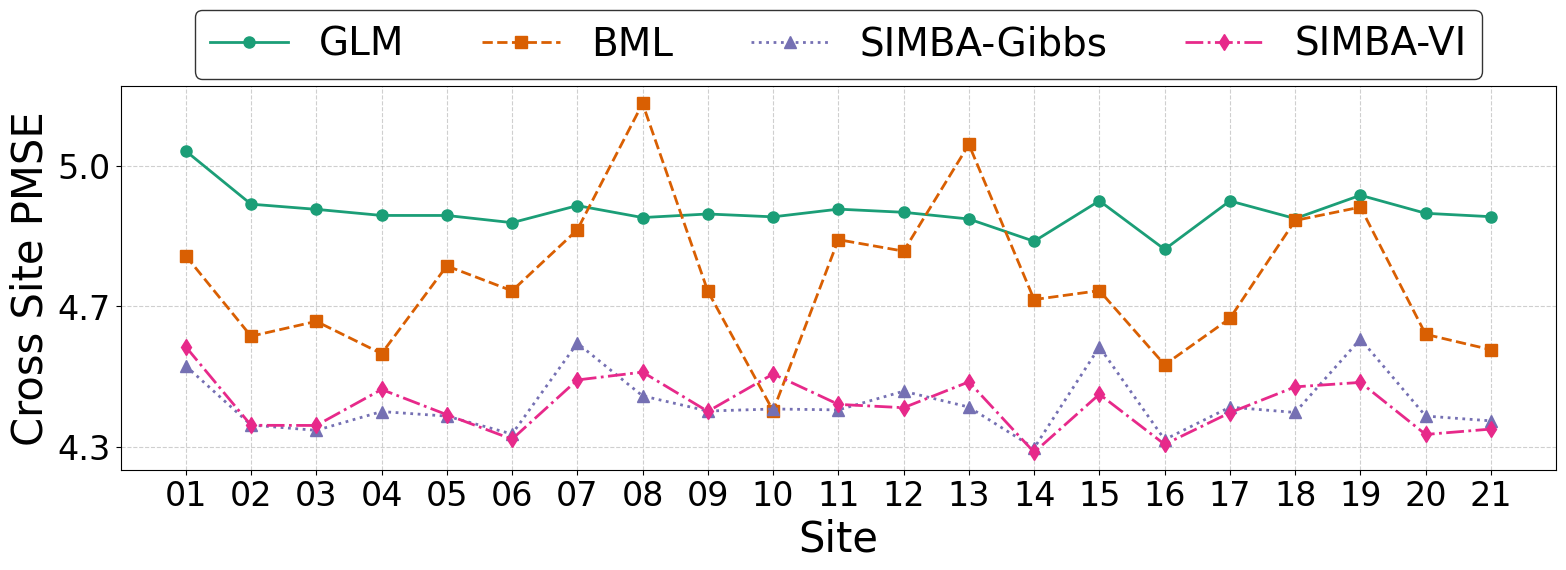

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

# Sample data (replace these with your actual data)
sites = np.arange(1, 22)  # Site indices (1 to 21)
glm = df['GLM']
mbl = df['BML']
gibbs = df['SIMBA-Gibbs']
vi = df['SIMBA-VI']

# Improved color scheme
cmap = cm.Dark2
colors  = [cmap(i ) for i in range(4)]

# Initialize the plot
plt.figure(figsize=(16, 6))

# Plot each line with different line styles and colors
plt.plot(sites, glm, '-o', color=colors[0], linestyle='-', label='GLM', linewidth=2, markersize=8)
plt.plot(sites, mbl, '--s', color=colors[1], linestyle='--', label='BML', linewidth=2, markersize=8)
plt.plot(sites, gibbs, ':^', color=colors[2], linestyle=':', label='SIMBA-Gibbs', linewidth=2, markersize=8)
plt.plot(sites, vi, '-.d', color=colors[3], linestyle='-.', label='SIMBA-VI', linewidth=2, markersize=8)

# Improve aesthetics
#plt.title('Cross Site Prediction MSE', fontsize=16, fontweight='normal')
plt.xlabel('Site', fontsize=30, fontweight='normal')
plt.ylabel('Cross Site PMSE', fontsize=30, fontweight='normal')
plt.xticks(sites, labels=[f'{i:02d}' for i in sites], fontsize=24)  # Format x-axis ticks as "01", "02", etc.
yticks = np.linspace(4.3, 5.0, 3)
ytick_labels = [f"{y:.1f}" for y in yticks]
plt.yticks(yticks, labels=ytick_labels, fontsize=24)
plt.grid(True, linestyle='--', alpha=0.6)

# Add legend at the top
plt.legend(fontsize=28, frameon=True, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.25), edgecolor='black')
#plt.legend(fontsize=20, loc='right')
# Optimize layout
plt.tight_layout()

# Save the figure (optional)
#plt.savefig(f'eval/abcd/{time}_{hemi}_mse_plot3.jpeg', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()
